In [1]:
import os
import pandas as pd
import plotting
import importlib
importlib.reload(plotting)
import numpy as np
import matplotlib.pyplot as plt 
pd.set_option("display.max_columns", None)  # show all columns

In [2]:
def load_data(data_src):
    curve_data = [] # used for plotting
    filename_list = []
    for filename in os.listdir(data_src):
        df = pd.read_csv(f"{data_src}/{filename}")
        curve_data.append(df)
        filename_list.append(filename)
    return curve_data, filename_list

data_src = "data/cleaned_data"
curve_data, filename_list = load_data(data_src)
filename_to_depth_resist = dict(zip(filename_list, curve_data))

data_features = pd.read_csv("data/features.csv")
all_num_features = plotting.extract_numerical_features(data_features)

ylabel_name = 'marions_ylabels'
# ylabel_name = 'marions_ylabels'
ylabel_to_cluster_num = {'ES-B':0, 'ES-BW':1, 'ES-S':2, 'ES-S-Plates':3, 'ES-D':4, 'LS':5, 'F':6, 'LS/F':7, 'ES-DB':8, 'ES': 9}
data_features[f'{ylabel_name}_nums'] = data_features[ylabel_name].map(ylabel_to_cluster_num)
labeled_data = data_features[data_features[ylabel_name].notna()].copy() # removes NaN's which correspond to non-labled data
labeled_num_features = plotting.extract_numerical_features(labeled_data)
print(labeled_num_features.columns)

Index(['depth_max', 'largest_force_drop_size', 'curve_first_quarter_slope',
       'force_mean', 'rsquared'],
      dtype='object')


# Correlation Matrix

In [3]:
corr_matrix = all_num_features.corr()
corr_matrix.to_csv(f"data/correlation_matrix.csv", index=False)
print(corr_matrix)

                           depth_max  largest_force_drop_size  \
depth_max                   1.000000                 0.417670   
largest_force_drop_size     0.417670                 1.000000   
curve_first_quarter_slope  -0.574720                -0.248569   
force_mean                 -0.594681                -0.237682   
rsquared                   -0.275990                -0.695212   

                           curve_first_quarter_slope  force_mean  rsquared  
depth_max                                  -0.574720   -0.594681 -0.275990  
largest_force_drop_size                    -0.248569   -0.237682 -0.695212  
curve_first_quarter_slope                   1.000000    0.632648  0.214417  
force_mean                                  0.632648    1.000000  0.368346  
rsquared                                    0.214417    0.368346  1.000000  


# F-Score (Fisher Score)
Compares how much a feature varies between different classes versus how much it varies within the same class

/home/liam-bouffard/anaconda3/envs/env3.14/lib/python3.14/site-packages/sklearn/feature_selection/_univariate_selection.py:782: UserWarning: k=10 is greater than n_features=5. All the features will be returned.
  warnings.warn(


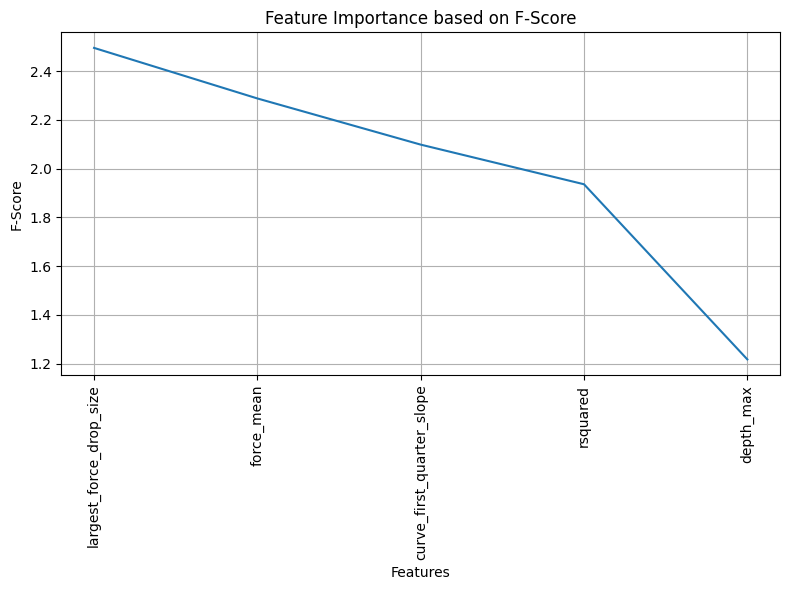

In [4]:
from sklearn.feature_selection import SelectKBest, f_classif

X = labeled_num_features.to_numpy() # numerical features
y = labeled_data[f'{ylabel_name}_nums'].to_numpy() # labels
selector = SelectKBest(score_func=f_classif)
selector.fit(X, y)
scores = selector.scores_

# display results
feature_scores = pd.DataFrame({'Feature': labeled_num_features.columns, 'Score': scores})
feature_scores = feature_scores.sort_values(by='Score', ascending=False)

Fig = plt.figure(figsize=(8, 6))
plt.plot(feature_scores['Feature'], feature_scores['Score'])
plt.xlabel('Features')
plt.ylabel('F-Score')  
plt.title('Feature Importance based on F-Score')
plt.xticks(rotation=90)  
plt.tight_layout()
plt.grid(True)
plt.show()

# Create a list of features sorted based on F-Score & no two features having corr > corr_thresh

In [5]:
def feature_selection(feature_scores, corr_matrix, corr_thresh, desired_features=[], undesired_features=[]):
    optimal_features = []
    if desired_features: optimal_features = desired_features

    for feature in feature_scores['Feature']: # loop through features
        if feature in undesired_features: continue

        above_thresh_mask = corr_matrix[feature].abs() > corr_thresh # get mask of other highly corr features
        above_thresh_mask[feature] = False  # ignore self-correlation
        high_corr_feature_idxs = corr_matrix[above_thresh_mask].index.tolist() # get high corr feature names

        if not any(f in optimal_features for f in high_corr_feature_idxs): # do any of these highly corr features exist in optimal features
            if feature not in optimal_features: # necessary if desired_features
                optimal_features.append(feature) # if not, then add feature to opt list

    return optimal_features

# optimal_features = feature_selection(feature_scores, corr_matrix, 0.7, desired_features=['rsquared'], undesired_features=['largest_force_drop']) 
optimal_features = feature_selection(feature_scores, corr_matrix, 0.7) 

print(optimal_features)

['largest_force_drop_size', 'force_mean', 'curve_first_quarter_slope', 'rsquared', 'depth_max']


# Save optimal feature set

In [6]:
non_num_features = data_features.drop(labeled_num_features.columns, axis=1)
# optimal_num_features = data_features[optimal_features[:7]].copy()
optimal_num_features = data_features[optimal_features].copy()
optimal_features = pd.concat([optimal_num_features, non_num_features], axis=1)
optimal_features.to_csv('data/optimal_features.csv', index=False)
print(optimal_num_features.columns.tolist())

['largest_force_drop_size', 'force_mean', 'curve_first_quarter_slope', 'rsquared', 'depth_max']
